In [1]:
CLASSES = (
    "__background__ ",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
import torchvision
from voc_dataset import get_voc
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch
from PIL import Image
import numpy as np

def get_prediction(dataset, idx, model):
    img, _ = dataset[idx]

    model.eval()
    with torch.no_grad():
        prediction = model([img])
    idx0 = torchvision.ops.nms(prediction[0]['boxes'],prediction[0]['scores'],0.25)
    idx1 = torchvision.ops.remove_small_boxes(prediction[0]['boxes'],60)
    idx = np.intersect1d(idx0,idx1)
    prediction[0]['boxes'] = prediction[0]['boxes'][idx]
    prediction[0]['scores'] = prediction[0]['scores'][idx]
    
    return img, prediction

def get_rects(boxes):
    rect = lambda x, y, w, h: patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')

    return [rect(box[0], box[1], box[2], box[3]) for box in boxes]

def get_clazzes(labels, boxes, index2class):
    return [{'x': box[0].item(), 'y': box[1].item() - 5.0, 's': index2class[label.item()], 'fontsize': 15,'c':'b'}
            for label, box in zip(labels, boxes)]

def show_prediction(img, index2class, fig, ax):
    pil_image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

    ax.imshow(pil_image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    for rect in get_rects(prediction[0]['boxes']):
        ax.add_patch(rect)


    for label in get_clazzes(prediction[0]['labels'], prediction[0]['boxes'], index2class):
        ax.text(**label)



In [3]:
dataset_val = get_voc('./data', 'val',train=False)

backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=21,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

model.load_state_dict(torch.load('model_MobileNet.pth',map_location='cpu'))

predictions = [get_prediction(dataset_val, i, model) for i in range(3)]

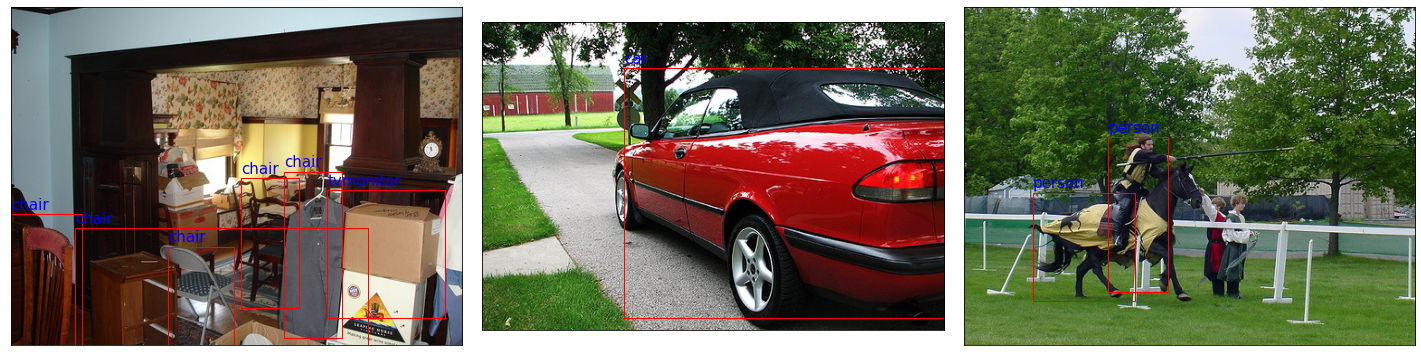

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
index2class = {i: CLASSES[i] for i in range(21)}

for (img, prediction), a in zip(predictions, ax):
    show_prediction(img, index2class, fig, a)

plt.tight_layout()